In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import operators
import lowlevelheuristics

In [2]:
class Plane(object):
    def __init__(self):
        self.i = None;
        self.a = None; #appearance time
        self.e = None; #earliest
        self.l = None; #latest
        self.t = None; #target
        self.s = [];   #required seperation
        self.g = None; #penalty before
        self.h = None; #penalty after
        
        self.x = -1; #actual landing time
        
    def clone(plane):
        clone = Plane()
        clone.i = plane.i
        clone.a = plane.a
        clone.e = plane.e
        clone.t = plane.t
        clone.l = plane.l
        clone.g = plane.g
        clone.h = plane.h
        clone.s = plane.s[:]
        
        clone.x = plane.x
        
        return clone
    
    def getFitness(self):
        if self.x == self.t:
            return 0
        if self.x > self.t:
            return (self.x - self.t) * self.h
        return (self.t - self.x) * self.g
    
    def __str__(self):
        result = 'appearance time: ' + str(self.a) + '\n' \
                 'earliest: ' + str(self.e) + '\n' \
                 'latest: ' + str(self.l) + '\n' \
                 'target: ' + str(self.t) + '\n' \
                 'penalty before: ' + str(self.g) + '\n' \
                 'penalty after: ' + str(self.h) + '\n' \
                 '--> actual: ' + str(self.x) + '\n' \
                 '--> fitness: ' + str(self.getFitness()) + '\n'
        result += str(self.s) + '\n\n'
        return result

In [3]:
location = './problems/'
prefix = 'airland'
fileType = '.txt'

problemsNumber = 13

problems = []
for i in range(1, problemsNumber + 1):
    problems.append([location + prefix + str(i) + fileType, prefix + str(i)])
    
problems

[['./problems/airland1.txt', 'airland1'],
 ['./problems/airland2.txt', 'airland2'],
 ['./problems/airland3.txt', 'airland3'],
 ['./problems/airland4.txt', 'airland4'],
 ['./problems/airland5.txt', 'airland5'],
 ['./problems/airland6.txt', 'airland6'],
 ['./problems/airland7.txt', 'airland7'],
 ['./problems/airland8.txt', 'airland8'],
 ['./problems/airland9.txt', 'airland9'],
 ['./problems/airland10.txt', 'airland10'],
 ['./problems/airland11.txt', 'airland11'],
 ['./problems/airland12.txt', 'airland12'],
 ['./problems/airland13.txt', 'airland13']]

In [4]:
problemIndex = 4

problemSetLines = pd.read_csv(problems[problemIndex][0], header=None).values.tolist()

problemSet = []
for line in problemSetLines: 
    problemSet.append(line[0].strip().split(' '))

problemSet

[['20', '35'],
 ['7', '82', '92', '510', '30.00', '30.00'],
 ['99999', '8', '15', '15', '8', '8', '8', '8'],
 ['8', '15', '15', '8', '8', '15', '8', '8'],
 ['8', '8', '8', '15'],
 ['9', '84', '93', '509', '30.00', '30.00'],
 ['8', '99999', '15', '15', '8', '8', '8', '8'],
 ['8', '15', '15', '8', '8', '15', '8', '8'],
 ['8', '8', '8', '15'],
 ['75', '150', '183', '599', '10.00', '10.00'],
 ['15', '15', '99999', '3', '15', '15', '15', '15'],
 ['15', '3', '3', '15', '15', '3', '15', '15'],
 ['15', '15', '15', '3'],
 ['129', '204', '270', '760', '10.00', '10.00'],
 ['15', '15', '3', '99999', '15', '15', '15', '15'],
 ['15', '3', '3', '15', '15', '3', '15', '15'],
 ['15', '15', '15', '3'],
 ['14', '89', '98', '510', '30.00', '30.00'],
 ['8', '8', '15', '15', '99999', '8', '8', '8'],
 ['8', '15', '15', '8', '8', '15', '8', '8'],
 ['8', '8', '8', '15'],
 ['29', '104', '117', '552', '30.00', '30.00'],
 ['8', '8', '15', '15', '8', '99999', '8', '8'],
 ['8', '15', '15', '8', '8', '15', '8', '8']

In [5]:
firstLine = problemSet.pop(0)
P = int(firstLine[0])
Freeze = int(firstLine[1])

P, Freeze

(20, 35)

In [6]:
planeList = []

done = False
planeIndex = 0
while planeIndex < P:
    planeIndex += 1
    props = problemSet.pop(0)
    i = Plane()
    i.i = planeIndex - 1
    i.a = int(props[0]) #appearance time, 
    i.e = int(props[1]) #earliest landing time, 
    i.t = int(props[2]) #target landing time,
    i.l = int(props[3]) #latest landing time, 
    i.g = float(props[4]) #penalty cost per unit of time for landing before target, 
    i.h = float(props[5]) #penalty cost per unit of time for landing after target
    while len(i.s) < P:
        sepTimes = map(int, problemSet.pop(0))
        i.s.extend(sepTimes)
        #separation time required after i lands before j can land
        
    planeList.append(i)
    
    

In [7]:
print(planeList[1])

appearance time: 9
earliest: 84
latest: 509
target: 93
penalty before: 30.0
penalty after: 30.0
--> actual: -1
--> fitness: 2820.0
[8, 99999, 15, 15, 8, 8, 8, 8, 8, 15, 15, 8, 8, 15, 8, 8, 8, 8, 8, 15]




In [8]:
class LandingSolution(object):
    def __init__(self):
        self.landingSolution = None
        
    def clone(self):
        clone = LandingSolution()
        clone.landingSolution = list(map(Plane.clone, self.landingSolution))
        return clone
        
    def constructRandomSolution(self, planes):
        # Loop while not a valid solution
        while not self.valid():
            self.landingSolution = []
            # Loop over planes and try create a solution
            for i, plane in enumerate(planes):
                plane.x = np.random.randint(low=plane.e, high=plane.l + 1)
                #print(plane)
                self.landingSolution.append(plane)
                
    def valid(self):
        if self.landingSolution == None: return False 
        for i, plane in enumerate(self.landingSolution):
            for j, seperation in enumerate(plane.s):
                if i == j: continue
                otherPlane = self.landingSolution[j]
                if plane.x <= otherPlane.x and plane.x + seperation >= otherPlane.x:
                    #print(i, plane, "== > ==\n", j, otherPlane)
                    return False
        return True
    
    def mutate(solution):
        clone = solution.clone()
        randomPlane = clone.landingSolution[np.random.randint(P)]
        randomPlane.x = np.random.randint(low=randomPlane.e, high=randomPlane.l + 1)
        while not clone.valid():
            clone = solution.clone()
            randomPlane = clone.landingSolution[np.random.randint(P)]
            randomPlane.x = np.random.randint(low=randomPlane.e, high=randomPlane.l + 1)
        return clone
    
    def swap(solution):
        clone = solution.clone()
        randomPlane1 = clone.landingSolution[np.random.randint(P)]
        randomPlane2 = clone.landingSolution[np.random.randint(P)]
        randomPlane1.x = randomPlane2.x
        randomPlane2.x = randomPlane1.x
        while not clone.valid():
            clone = solution.clone()
            randomPlane1 = clone.landingSolution[np.random.randint(P)]
            randomPlane2 = clone.landingSolution[np.random.randint(P)]
            randomPlane1.x = randomPlane2.x
            randomPlane2.x = randomPlane1.x
        return clone
    
    def swapCrossover(parent1, parent2):
        clone1 = parent1.clone()
        clone2 = parent2.clone()
        
        randomPlane1 = clone1.landingSolution[np.random.randint(P)]
        randomPlane2 = clone2.landingSolution[np.random.randint(P)]
        
        randomPlane1.x = randomPlane2.x
        randomPlane2.x = randomPlane1.x
        
        while not clone1.valid() and clone2.valid():
            clone1 = parent1.clone()
            clone2 = parent2.clone()

            randomPlane1 = clone1.landingSolution[np.random.randint(P)]
            randomPlane2 = clone2.landingSolution[np.random.randint(P)]

            randomPlane1.x = randomPlane2.x
            randomPlane2.x = randomPlane1.x
            
        return clone1, clone2
    
    def getFitness(self):
        sum = 0
        for i in self.landingSolution:
            sum += i.getFitness();
        return sum
    
    def __str__(self):
        result = ''
        for i, plane in enumerate(self.landingSolution):
            result += str(i) + '\n' + str(plane)
        return result

In [9]:
def createPopulation():
    result = []
    for i in range(POPULATION_SIZE):
        solution = LandingSolution()
        solution.constructRandomSolution(list(map(Plane.clone, planeList)))
        result.append(solution)
    return result
        

In [10]:
def getPopulationFitness(population):
    populationFitness = []
    for idx, individulal in enumerate(population):
        populationFitness.append(individulal.getFitness())
    
    return np.array(populationFitness)

In [11]:
def getPopulationHeuristicFitness(population, solution):
    populationFitness = []
    for idx, individulal in enumerate(population):
        populationFitness.append(individulal.getFitness(solution))
    
    return np.array(populationFitness)

In [12]:
def tournamentSelector(population, tournament_size=5):
    # Make the tournament
    random_indicies = np.random.randint(len(population), size=tournament_size).tolist()
    tournament = []
    for idx, val in np.ndenumerate(random_indicies):
        tournament.append(population[val])

    # Run the tournament
    fitnesss = getPopulationFitness(tournament)
    
    maxPos = np.argmax(fitnesss, axis=0)
    minPos = np.argmin(fitnesss, axis=0)
    
    return [random_indicies[minPos], fitnesss[minPos]], [random_indicies[maxPos], fitnesss[maxPos]]

In [13]:
def tournamentHeuristicSelector(population, solution, tournament_size=5):
    # Make the tournament
    random_indicies = np.random.randint(len(population), size=tournament_size).tolist()
    tournament = []
    for idx, val in np.ndenumerate(random_indicies):
        tournament.append(population[val])

    # Run the tournament
    fitnesss = getPopulationHeuristicFitness(tournament, solution)
    
    maxPos = np.argmax(fitnesss, axis=0)
    minPos = np.argmin(fitnesss, axis=0)
    
    return [random_indicies[minPos], fitnesss[minPos]], [random_indicies[maxPos], fitnesss[maxPos]]

In [14]:
def applyHeuristicToSolution(chromosome, solution):
    clone = solution.clone()
    for heuristic in chromosome:
        clone = heuristic(clone)
    return clone

In [15]:
class Chromosome(object):
    def __init__(self, chromosome):
        self.chromosome = chromosome
    def getFitness(self, solution):
        result = applyHeuristicToSolution(self.chromosome, solution)
        return result.getFitness()
        

In [16]:
def geneticHeuristicAlgorithm(population, solution):
    newPop = population[:]
    
    for i in range(NUM_MUTATE):
        best, worst = tournamentHeuristicSelector(population, solution, tournament_size=TOURNAMENT_SIZE)
        #print('before', newPop[worst[0]].getFitness(solution))
        #print('before', newPop[worst[0]].chromosome)
        newPop[worst[0]] = Chromosome(operators.swap(newPop[best[0]].chromosome))
        #print('after', newPop[worst[0]].chromosome)
        #print('after', newPop[worst[0]].getFitness(solution))
        
    for i in range(NUM_CROSSOVER):    
        best1, worst1 = tournamentHeuristicSelector(population, solution, tournament_size=TOURNAMENT_SIZE)
        best2, worst2 = tournamentHeuristicSelector(population, solution, tournament_size=TOURNAMENT_SIZE)
        result1, result2 = operators.crossover(newPop[best1[0]].chromosome, newPop[best2[0]].chromosome)
        newPop[worst1[0]] = Chromosome(result1)
        newPop[worst2[0]] = Chromosome(result2)
    
    return newPop

In [17]:
def geneticAlgorithm(population):
    newPop = population[:]
    
    for i in range(NUM_MUTATE):    
        best, worst = tournamentSelector(population, tournament_size=TOURNAMENT_SIZE)
        newPop[worst[0]] = LandingSolution.mutate(population[best[0]])
        
    for i in range(NUM_CROSSOVER):    
        best1, worst1 = tournamentSelector(population, tournament_size=TOURNAMENT_SIZE)
        best2, worst2 = tournamentSelector(population, tournament_size=TOURNAMENT_SIZE)
        result1, result2 = LandingSolution.swapCrossover(population[best1[0]], population[best2[0]])
        newPop[worst1[0]] = result1
        newPop[worst2[0]] = result2
    
    return newPop

In [18]:
def randomHeuristicSelection(heuristics):
    randomIndex = np.random.randint(len(heuristics))
    return heuristics[randomIndex]

def acceptAll(prevSolution, nextSolution):
    return True
    
def acceptIfImproving(prevSolution, nextSolution):
    return nextSolution.getFitness() < prevSolution.getFitness()

def acceptIfEqualOrImproving(prevSolution, nextSolution):
    return nextSolution.getFitness() <= prevSolution.getFitness()

def shiftUp(solution):
    newSolution = solution.clone()
    sortedPlanes = [i[0] for i in sorted(enumerate(newSolution.landingSolution), key=lambda x: x[1].x, reverse=False)]
    prev = None
    for i in sortedPlanes:
        if prev == None:
            prev = newSolution.landingSolution[i]
            continue
        if prev.x + prev.s[newSolution.landingSolution[i].i] + 1 <= newSolution.landingSolution[i].x:
            newSolution.landingSolution[i].x = prev.x + prev.s[newSolution.landingSolution[i].i] + 1
            if newSolution.valid():
                return newSolution
            else:
                newSolution = solution.clone()
        else:
            prev = newSolution.landingSolution[i]
        
    return solution

def shiftUpReversed(solution):
    newSolution = solution.clone()
    sortedPlanes = [i[0] for i in sorted(enumerate(newSolution.landingSolution), key=lambda x: x[1].x, reverse=True)]
    prev = None
    for i in sortedPlanes:
        if prev == None:
            prev = newSolution.landingSolution[i]
            continue
        if prev.x + prev.s[newSolution.landingSolution[i].i] + 1 <= newSolution.landingSolution[i].x:
            newSolution.landingSolution[i].x = prev.x + prev.s[newSolution.landingSolution[i].i] + 1
            if newSolution.valid():
                return newSolution
            else:
                newSolution = solution.clone()
        else:
            prev = newSolution.landingSolution[i]
        
    return solution

def shiftDown(solution):
    newSolution = solution.clone()
    sortedPlanes = [i[0] for i in sorted(enumerate(newSolution.landingSolution), key=lambda x: x[1].x, reverse=False)]
    prev = None
    for i in sortedPlanes:
        if prev == None:
            prev = i
            continue
        if newSolution.landingSolution[prev].x + newSolution.landingSolution[prev].s[i] + 1 <= newSolution.landingSolution[i].x:
            newSolution.landingSolution[prev].x = newSolution.landingSolution[prev].x + newSolution.landingSolution[prev].s[i] + 1
            if newSolution.valid():
                return newSolution
            else:
                newSolution = solution.clone()
        else:
            prev = i
        
    return solution

def shiftDownReversed(solution):
    newSolution = solution.clone()
    sortedPlanes = [i[0] for i in sorted(enumerate(newSolution.landingSolution), key=lambda x: x[1].x, reverse=True)]
    prev = None
    for i in sortedPlanes:
        if prev == None:
            prev = i
            continue
        if newSolution.landingSolution[prev].x + newSolution.landingSolution[prev].s[i] + 1 <= newSolution.landingSolution[i].x:
            newSolution.landingSolution[prev].x = newSolution.landingSolution[prev].x + newSolution.landingSolution[prev].s[i] + 1
            if newSolution.valid():
                return newSolution
            else:
                newSolution = solution.clone()
        else:
            prev = i
        
    return solution

def tryMoveHighestCloseToTarget(solution):
    newSolution = solution.clone()
    sortedPlanes = [i[0] for i in sorted(enumerate(newSolution.landingSolution), key=lambda x: x[1].getFitness(), reverse=True)]
    for i in sortedPlanes:
        newSolution.landingSolution[i].x = newSolution.landingSolution[i].t
        if newSolution.valid():
            return newSolution
        else:
            newSolution = solution.clone()
    return solution

def tryMoveHighestCloseToTargetReversed(solution):
    newSolution = solution.clone()
    sortedPlanes = [i[0] for i in sorted(enumerate(newSolution.landingSolution), key=lambda x: x[1].getFitness(), reverse=False)]
    for i in sortedPlanes:
        newSolution.landingSolution[i].x = newSolution.landingSolution[i].t
        if newSolution.valid():
            return newSolution
        else:
            newSolution = solution.clone()
    return solution

def trySwap(solution):
    newSolution = solution.clone()
    sortedPlanes = [i[0] for i in sorted(enumerate(newSolution.landingSolution), key=lambda x: x[1].getFitness(), reverse=True)]
    for x in sortedPlanes:
        for i in sortedPlanes:
            if x == i:
                continue
            tempX = newSolution.landingSolution[i].x
            newSolution.landingSolution[i].x = newSolution.landingSolution[x].x
            newSolution.landingSolution[x].x = tempX
            if newSolution.valid():
                return newSolution
            else:
                newSolution = solution.clone()
    return solution

def trySwapReversed(solution):
    newSolution = solution.clone()
    sortedPlanes = [i[0] for i in sorted(enumerate(newSolution.landingSolution), key=lambda x: x[1].getFitness(), reverse=False)]
    for x in sortedPlanes:
        for i in sortedPlanes:
            if x == i:
                continue
            tempX = newSolution.landingSolution[i].x
            newSolution.landingSolution[i].x = newSolution.landingSolution[x].x
            newSolution.landingSolution[x].x = tempX
            if newSolution.valid():
                return newSolution
            else:
                newSolution = solution.clone()
    return solution

def randomMove(solution):
    newSolution = solution.clone()
    sortedPlanes = [i[0] for i in sorted(enumerate(newSolution.landingSolution), key=lambda x: x[1].getFitness(), reverse=True)]
    for x in sortedPlanes:
        newSolution.landingSolution[x].x = np.random.randint(low=newSolution.landingSolution[x].e, high=newSolution.landingSolution[x].l + 1)
        if newSolution.valid():
            return newSolution
        else:
            newSolution = solution.clone()
    return solution

def doNothing(solution):
    return solution

In [19]:
POPULATION_SIZE = 15

GENERATIONS = 100
PARTIAL_GENERATIONS = 100
TOURNAMENT_SIZE = 3

MUTATION_RATE = 0.5
CROSSOVER_RATE = 0.3

MIN_CHROMOSOME_SIZE = 20
MAX_CHROMOSOME_SIZE = 30

NUM_MUTATE = int(MUTATION_RATE * POPULATION_SIZE)
NUM_CROSSOVER = int(CROSSOVER_RATE * POPULATION_SIZE)
NUM_REPRODUCTION = POPULATION_SIZE - (NUM_MUTATE + NUM_CROSSOVER)

assert NUM_REPRODUCTION >= 0

SAMPLES = 15

REPORT_RATE = 1

heuristics = [
    tryMoveHighestCloseToTarget,
    tryMoveHighestCloseToTargetReversed,
    trySwap,
    trySwapReversed,
    shiftUp,
    shiftUpReversed,
    shiftDown,
    shiftDownReversed
]

heuristicSelectors = [
    [randomHeuristicSelection, "random"]
]

moveAcceptanceTechniques = [
    [acceptAll, "accept all moves"],
    [acceptIfImproving, "improving moves"],
    [acceptIfEqualOrImproving, "equal or improving moves"]
]        

In [20]:
overTimeResult = []
finalResultMean = []
finalResultStd = []
finalResultMin = []
for heuristicSelector in heuristicSelectors:
    for moveAcceptanceTechnique in moveAcceptanceTechniques:
        print(heuristicSelector[1], moveAcceptanceTechnique[1])

        
        samplesOverTimeResult = []
        samplesFinalResult = []
        for sample in range(SAMPLES):
            print(sample)
            sampleOverTimeResult = []
            
            solution = LandingSolution()
            solution.constructRandomSolution(list(map(Plane.clone, planeList)))
            best = solution
            for gen in range(GENERATIONS):
                heuristic = heuristicSelector[0](heuristics)
                potentialSolution = heuristic(solution)
                if moveAcceptanceTechnique[0](solution, potentialSolution):
                    solution = potentialSolution
                if acceptIfImproving(best, solution):
                    best = solution
                if gen % REPORT_RATE == 0:
                    sampleOverTimeResult.append(best.getFitness())
            
            samplesFinalResult.append(best.getFitness())
            samplesOverTimeResult.append(sampleOverTimeResult)
            
        # Each type
        overTimeResult.append([np.mean(samplesOverTimeResult, axis=0), heuristicSelector[1], moveAcceptanceTechnique[1]])
        finalResultMean.append([np.mean(samplesFinalResult), heuristicSelector[1], moveAcceptanceTechnique[1]])
        finalResultStd.append([np.std(samplesFinalResult), heuristicSelector[1], moveAcceptanceTechnique[1]])
        finalResultMin.append([np.min(samplesFinalResult), heuristicSelector[1], moveAcceptanceTechnique[1]])

random accept all moves
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
random improving moves
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
random equal or improving moves
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [21]:
   
def generateChromosome(heuristics):
    chromosome = []
    chromosomeLength = np.random.randint(low=MIN_CHROMOSOME_SIZE,high=MAX_CHROMOSOME_SIZE)
    for i in range(chromosomeLength):
        heuristicChoice = np.random.randint(len(heuristics))
        chromosome.append(heuristics[heuristicChoice])
        
    return chromosome


def createHeuristicPopulation(heuristics):
    population = []
    for i in range(POPULATION_SIZE):
        population.append(Chromosome(generateChromosome(heuristics)))

    return population

def printPopulation(population):
    for ind in population:
        print(ind.chromosome)


In [22]:
print('genetic alg')



        
samplesOverTimeResult = []
samplesFinalResult = []
for sample in range(SAMPLES):
    print(sample)
    sampleOverTimeResult = []


    population = createPopulation()
    solution = population[0]
    best = population[0]
    for gen in range(GENERATIONS):
        population = geneticAlgorithm(population)
        if gen % REPORT_RATE == 0:
            fitnesss = getPopulationFitness(population)
            min = np.argmin(fitnesss, axis=0)
            solution = population[min]
        if acceptIfImproving(best, solution):
            best = solution
        if gen % REPORT_RATE == 0:
            sampleOverTimeResult.append(best.getFitness())

    samplesFinalResult.append(best.getFitness())
    samplesOverTimeResult.append(sampleOverTimeResult)

# Each type
overTimeResult.append([np.mean(samplesOverTimeResult, axis=0), 'genetic alg', ''])
finalResultMean.append([np.mean(samplesFinalResult), 'genetic alg', ''])
finalResultStd.append([np.std(samplesFinalResult), 'genetic alg', ''])
finalResultMin.append([np.min(samplesFinalResult), 'genetic alg', ''])

genetic alg
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [23]:
print('genetic alg hyper heuristic')
        
samplesOverTimeResult = []
samplesFinalResult = []
for sample in range(SAMPLES):
    print(sample)
    sampleOverTimeResult = []

    population = createHeuristicPopulation(heuristics)
    thissolution = LandingSolution()
    thissolution.constructRandomSolution(list(map(Plane.clone, planeList)))
    current = Chromosome(population[0].chromosome.copy())
    best = Chromosome(population[0].chromosome.copy())
    for gen in range(GENERATIONS):
        population = geneticHeuristicAlgorithm(population, thissolution.clone())
        if gen % REPORT_RATE == 0:
            fitnesss = getPopulationHeuristicFitness(population, thissolution.clone())
            min = np.argmin(fitnesss, axis=0)
            current = Chromosome(population[min].chromosome.copy())
        if best.getFitness(thissolution.clone()) > current.getFitness(thissolution.clone()):
            best = Chromosome(current.chromosome.copy())
            print('best', best.getFitness(thissolution.clone()))
        if gen % REPORT_RATE == 0:
            sampleOverTimeResult.append(best.getFitness(thissolution.clone()))

#     while len(sampleOverTimeResult) != GENERATIONS:
#         sampleOverTimeResult.append(best.getFitness(thissolution.clone()))
    samplesFinalResult.append(best.getFitness(thissolution.clone()))
    samplesOverTimeResult.append(sampleOverTimeResult)


# Each type
overTimeResult.append([np.mean(samplesOverTimeResult, axis=0), 'genetic alg hyper heuristic', ''])
finalResultMean.append([np.mean(samplesFinalResult), 'genetic alg hyper heuristic', ''])
finalResultStd.append([np.std(samplesFinalResult), 'genetic alg hyper heuristic', ''])
finalResultMin.append([np.min(samplesFinalResult), 'genetic alg hyper heuristic', ''])

genetic alg hyper heuristic
0
best 63860.0
best 62840.0
best 54240.0
best 53000.0
best 52160.0
best 51720.0
best 51640.0
best 51440.0
best 50890.0
best 50690.0
best 50630.0
best 50600.0
1
best 65380.0
best 65020.0
best 64820.0
best 62740.0
best 62540.0
2
best 60990.0
best 59820.0
best 58500.0
best 58470.0
best 57240.0
3
best 67390.0
best 60690.0
best 60600.0
best 60210.0
4
best 65710.0
best 65200.0
best 62220.0
best 57380.0
best 49920.0
best 49150.0
best 49070.0
best 47430.0
best 46440.0
5
best 59370.0
best 57210.0
best 56940.0
best 52860.0
best 50250.0
best 49370.0
best 46770.0
best 43250.0
6
best 70400.0
best 68420.0
best 66200.0
best 65900.0
best 65330.0
7
best 59390.0
best 58310.0
best 57500.0
8
best 61530.0
best 60420.0
best 55170.0
best 54900.0
best 51650.0
best 48770.0
best 48550.0
best 48470.0
best 47070.0
9
best 65030.0
best 64280.0
best 64130.0
best 63350.0
best 63200.0
best 60890.0
best 60110.0
10
best 74420.0
best 71650.0
best 68270.0
best 67660.0
best 59290.0
best 58300.0


random
random
random
genetic alg
genetic alg hyper heuristic


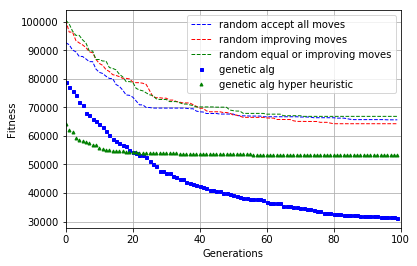

In [24]:
fig = plt.figure()
plt.grid(1)
plt.xlim([0, GENERATIONS])
plt.ion()
plt.xlabel('Generations')
plt.ylabel('Fitness')

generations = np.arange(0, GENERATIONS, REPORT_RATE)

plotColors = [
    'b--',
    'r--',
    'g--',
    'bs',
    'g^',
    'k'
]

plots = []
descriptions = []
for x, result in enumerate(overTimeResult):
    print(result[1])
    plots.append(plt.plot(generations, result[0], plotColors[x%len(plotColors)] , linewidth=1, markersize=3)[0])
    descriptions.append(result[1] + ' ' + result[2])

plt.legend(plots, descriptions)
fig.savefig(problems[problemIndex][1] + '.png')
plt.show(5)

plt.close()

In [25]:
padding = [None, None, None, None]

problem = []
problem.append(problemIndex + 1)
problem.extend(padding)

d = {
     'problem': problem,
     'type': list(map(lambda x: x[1] + ' ' + x[2], finalResultMean)),
     'mean': list(map(lambda x: x[0], finalResultMean)),
     'std': list(map(lambda x: x[0], finalResultStd)),
     'max': list(map(lambda x: x[0], finalResultMin))
    }

df = pd.DataFrame(data=d)

list(df.columns.values)

result = df[['problem', 'type', 'mean', 'std', 'max']]
result

,problem,type,mean,std,max
0,4.0,random accept all moves,65648.0,7636.684446,52950.0
1,NaN,random improving moves,64280.0,12241.595757,43920.0
2,NaN,random equal or improving moves,66854.0,10398.229849,44160.0
3,NaN,genetic alg,31278.0,3707.846095,24980.0
4,NaN,genetic alg hyper heuristic,53402.0,6752.316343,43250.0


In [26]:
print(result.to_latex(index=False, bold_rows=True, na_rep=''))
with open(problems[problemIndex][1] + '.txt', 'w') as f:
    print(result.to_latex(index=False, bold_rows=True, na_rep=''), file=f)

\begin{tabular}{rlrrr}
\toprule
 problem &                             type &     mean &           std &      max \\
\midrule
     4.0 &          random accept all moves &  65648.0 &   7636.684446 &  52950.0 \\
         &           random improving moves &  64280.0 &  12241.595757 &  43920.0 \\
         &  random equal or improving moves &  66854.0 &  10398.229849 &  44160.0 \\
         &                     genetic alg  &  31278.0 &   3707.846095 &  24980.0 \\
         &     genetic alg hyper heuristic  &  53402.0 &   6752.316343 &  43250.0 \\
\bottomrule
\end{tabular}

